Atividade 05 da disciplina de Visão Robótica

Discente: Henrique Antônio Guanais Corneau

# Corners e Rastreamento

1. Implemente uma função para detectar pontos Harris em uma
imagem

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Para realizar o Harris corner detector, primeiramente é necessário aplicar o filtro de sobel na imagem, para calcular a primeira derivada na direção x e y, com o objetivo de encontrar cantos.

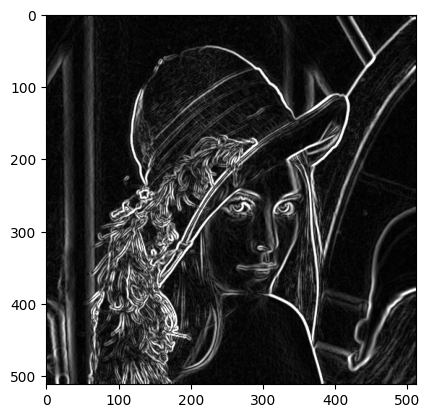

In [2]:
# filtro de sobel
img = cv2.imread("../imagens/Lenna.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gauss = cv2.GaussianBlur(img_gray, (3, 3), 0)

sobel_x = cv2.Sobel(img_gauss, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img_gauss, cv2.CV_64F, 0, 1, ksize=3)
magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
img_filtro_sobel = cv2.convertScaleAbs(magnitude)

plt.imshow(img_filtro_sobel, cmap='gray')
plt.show()


O próximo passo é calcular a matriz M, chamada de matriz de Harris:
$$
M = \sum_w 
\begin{bmatrix}
I_x^2 & I_x I_y \\ 
I_x I_y & I_y^2
\end{bmatrix}
$$

Em que Ix representa a derivada em x (sobel x) e Iy a derivada em y (sobel y). Com isso será calculado $ I_x^2, \ I_y^2, \ I_x \cdot I_y $
Para calcular as somas de cada um desses elementos, basta realizar a filtragem espacial com um kernel com todos os valores iguais a 1: 
````
soma_Ix2 = filtragem_espacial(Ix2, kernel)
soma_Iy2 = filtragem_espacial(Iy2, kernel)
soma_Ixy = filtragem_espacial(Ixy, kernel)
````

Com a matriz M calculada, agora é necessário calcular a matriz R, em que a equação é:
$$ R = \det(M) - k \cdot \text{tr}(M)^2 $$

Para calcular o determinante da matriz M, foi feito: `determinante = soma_Ix2 * soma_Iy2 - (soma_Ixy**2)`, e para calcular o traço da matriz: `traco = soma_Ix2 + soma_Iy2`

Valores positivos altos de 𝑅 indicam cantos, valores negativos altos, bordas
e valores baixos regiões constantes. 

Após essa etapa os valores dessa matriz R serão normalizados e filtrados através de um valor de threshold, será também aplicado um non-maximum supression para evitar detecções repetidas.

Por fim, a função `draw_corners()` irá desenhar na imagem original todos os cantos encontrados.


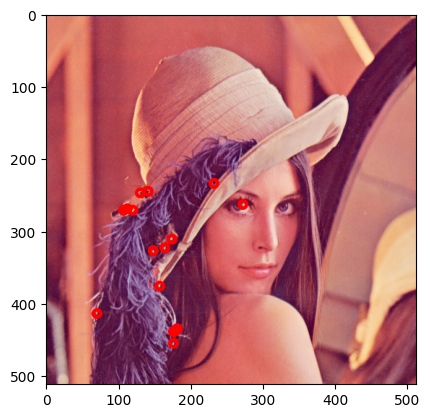

In [ ]:
def filtragem_espacial(img, k):
    img2 = np.zeros_like(img, dtype=np.float32)
    lk = k.shape[0] 
    ck = k.shape[1] 
    llin = int(lk/2) 
    lcol = int(ck/2)
    
    for i in range(llin, img.shape[0] - llin):
        for j in range(lcol, img.shape[1] - lcol):
            region = img[i - llin:i + llin + 1, j - lcol:j + lcol + 1]
            img2[i, j] = np.sum(region * k)

    return img2

def harris_corner(sobel_x, sobel_y, k, threshold):
    Ix2 = sobel_x**2
    Iy2 = sobel_y**2
    Ixy = sobel_x * sobel_y
    kernel = np.ones((3, 3))
    # a soma e a convolucao com o kernel 3x3 de uns
    soma_Ix2 = filtragem_espacial(Ix2, kernel)
    soma_Iy2 = filtragem_espacial(Iy2, kernel)
    soma_Ixy = filtragem_espacial(Ixy, kernel)

    determinante = soma_Ix2 * soma_Iy2 - (soma_Ixy**2)
    traco = soma_Ix2 + soma_Iy2

    R = determinante - k * (traco**2)

    R = determinante - k * (traco**2)
    R = R / np.max(R)
    R[R < threshold] = 0
    # non maximum suppression 3x3
    for i in range(1, R.shape[0] - 1):
        for j in range(1, R.shape[1] - 1):
            if R[i, j] != 0:
                if R[i, j] < R[i - 1, j - 1]:
                    R[i, j] = 0
                if R[i, j] < R[i - 1, j]:
                    R[i, j] = 0
                if R[i, j] < R[i - 1, j + 1]:
                    R[i, j] = 0
                if R[i, j] < R[i, j - 1]:
                    R[i, j] = 0
                if R[i, j] < R[i, j + 1]:
                    R[i, j] = 0
                if R[i, j] < R[i + 1, j - 1]:
                    R[i, j] = 0
                if R[i, j] < R[i + 1, j]:
                    R[i, j] = 0
                if R[i, j] < R[i + 1, j + 1]:
                    R[i, j] = 0
    
    return R

def draw_corners(img, harris_corners):
    img2 = img.copy()
    for i in range(harris_corners.shape[0]):
        for j in range(harris_corners.shape[1]):
            if harris_corners[i, j] != 0:
                cv2.circle(img2, (j, i), 5, (0, 0, 255), 3)

    return img2

k = 0.04
threshold = 0.3
harris = harris_corner(sobel_x, sobel_y, k, threshold)
img_corners = draw_corners(img, harris)

plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
plt.show()



2. Sendo a entrada de uma função os pontos detectados no passo
anterior, implemente uma função para realizar o rastreamento
destes pontos por Template matching considerando uma janela em torno dos
pontos

Para calcular a correlação de pontos de uma imagem com outra, é necessário calcular a correlação normalizada com média subtraída, aplicando essa fórmula:
$$
\text{corr}(x, y) = \frac{\sum_{k, l} \left( (I_w(x+k, y+l) - \bar{I}_w) \cdot (T(k, l) - \bar{T}) \right)}{\sqrt{\sum_{k, l} (I_w(x+k, y+l) - \bar{I}_w)^2} \cdot \sqrt{\sum_{k, l} (T(k, l) - \bar{T})^2}}
$$

Em que $ I_w $ é a região da imagem sob o template, $\bar{I}_w$ é a média da região da imagem sob o template, $T$ é o template e $\bar{T}_w$ é a média dos valores do template.

Primeiramente, na função `template_matching()`, para cada corner, será calculado um template com a janela 3x3 ao redor dele.

Após isso, será chamada a função `correlacao_normalizada()`, em que segue o mesmo princípio da filtragem espacial, será calculado `region`, que é a região $ I_w $, e após isso, serão feito todos os cálculos necessários para a equação da correlação:

```
region = img[i - llin:i + llin + 1, j - lcol:j + lcol + 1]

mean_Iw = np.mean(region)
numerador = np.sum((region - mean_Iw) * (T - mean_T))           
# Denominadores
denominador_Iw = np.sqrt(np.sum((region - mean_Iw) ** 2))
denominador_T = np.sqrt(np.sum((T - mean_T) ** 2))       
# Correlação normalizada
corr = numerador / (denominador_Iw * denominador_T)
```

Por fim, a cada coordenada dos corners de Harris, é atribuido um valor de correlação na matriz `new_corr`.


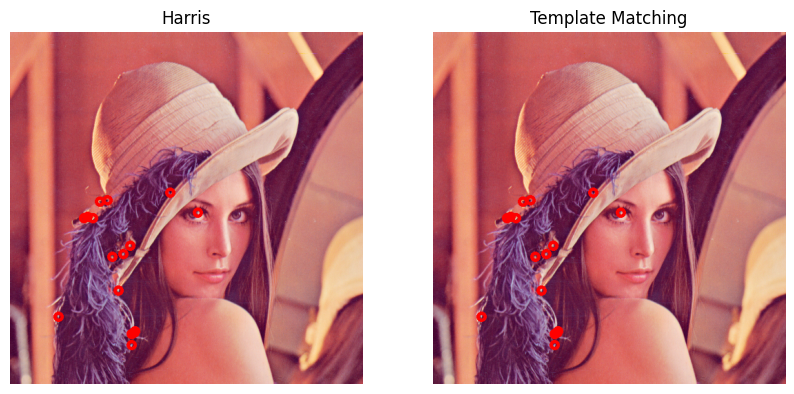

In [10]:
def correlacao_normalizada(img, T):
    lk = T.shape[0] 
    ck = T.shape[1] 
    llin = int(lk/2) 
    lcol = int(ck/2)
    mean_T = np.mean(T)

    for i in range(llin, img.shape[0] - llin):
        for j in range(lcol, img.shape[1] - lcol):
            region = img[i - llin:i + llin + 1, j - lcol:j + lcol + 1]

            mean_Iw = np.mean(region)
            numerador = np.sum((region - mean_Iw) * (T - mean_T))
            
            # Denominadores
            denominador_Iw = np.sqrt(np.sum((region - mean_Iw) ** 2))
            denominador_T = np.sqrt(np.sum((T - mean_T) ** 2))
            
            # Correlação normalizada
            corr = numerador / (denominador_Iw * denominador_T)
            
    return corr

def template_matching(img1, img2, corners, janela=3):
    new_corr = np.zeros_like(img2, dtype=np.float32)

    for i in range(corners.shape[0]):
        for j in range(corners.shape[1]):
            if corners[i, j] != 0:
                T = img1[i - janela:i + janela + 1, j - janela:j + janela + 1]
                new_corr[i, j] = correlacao_normalizada(img2, T)
    
    return new_corr

new_corr = template_matching(img_gray, img_gray, harris)
img_corners2 = draw_corners(img, new_corr)

plt.figure(figsize=(10, 10)) 
plt.subplot(1, 2, 1)
plt.title("Harris")
plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Template Matching")
plt.imshow(cv2.cvtColor(img_corners2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
